## Расчет несмещенной дисперсии,математического ожидания и проверка соответствия закона распределения эмпирическим данным

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

### 1. Импорт данных

#### Загрузка всех файлов и обработка потенциальных ошибок

In [5]:
file_names = ["set_1.csv", "set_2.csv", "set_3.csv"]
datasets: list[np.ndarray] = []

for file_name in file_names:
    try:
        with open(file_name, "r") as file:
            line = file.readline()
            file_data: np.ndarray = np.array([float(x) for x in line.strip().split(",")])

        datasets.append(file_data)
        print(
            f"Файл {file_name} загружен. Прочитано {len(file_data)} элементов."
        )
    except FileNotFoundError:
        # Файл не найден
        print(f"Ошибка: файл {file_name} не найден.")
    except ValueError:
        # Некорректные данные
        print(f"Ошибка: файл {file_name} содержит некорректные данные.")
    except Exception as e:
        # Другие ошибки
        print(f"Ошибка при обработке файла {file_name}: {e}")

if not datasets:
    print("Файлы не были загружены.")
else:
    print("Данные успешно загружены.")

Файл set_1.csv загружен. Прочитано 100000 элементов.
Файл set_2.csv загружен. Прочитано 10000 элементов.
Файл set_3.csv загружен. Прочитано 100000 элементов.
Данные успешно загружены.


### 2. Анализ данных

#### Функции для расчета математического ожидания и несмещенной дисперсии для каждого набора данных

##### Математическое ожидание означает среднее (взвешенное по вероятностям возможных значений) значение случайной величины.

$$ m_x = M[X] = \sum_{i=1}^{n} x_i \cdot p_i $$

##### Дисперсия случайной величины — мера разброса значений случайной величины относительно её математического ожидания.

$$ s^2 = \frac{1}{n-1} \sum_{i=1}^{n} \left(x_i - \bar{x}\right)^2 $$

In [6]:
def calculate_mean(data) -> float:
    if len(data) == 0:
        raise ValueError("Массив данных пуст.")
    mean = sum(data) / len(data)
    return mean


def calculate_unbiased_variance(data):
    """
    Несмещённая дисперсия:
    s² = (1/(n-1)) * Σ (xᵢ - μ)²,
    где μ — среднее арифметическое, а n — число наблюдений.
    """
    count = len(data)

    if count < 2:
        raise ValueError("Некорректное количество значений.")

    mean_val = calculate_mean(data)
    sum_sq = 0.0
    for x in data:
        sum_sq += (x - mean_val) ** 2
    return sum_sq / (count - 1)

#### Вычисление математического ожидания и несмещенной дисперсии для каждого набора данных

In [7]:
for i, dataset in enumerate(datasets, start=1):
    try:
        mean = calculate_mean(dataset)
        variance = calculate_unbiased_variance(dataset)
        print(f"Набор данных {i}:")
        print(f"M[x]: {mean}")
        print(f"D[x]: {variance}")
        print()
    except ValueError as e:
        print(f"Ошибка при расчете для набора данных {i}: {e}")

Набор данных 1:
M[x]: 3.44078
D[x]: 10.048293474525257

Набор данных 2:
M[x]: 16.243283213799984
D[x]: 10928.49747740112

Набор данных 3:
M[x]: 0.12448845074999802
D[x]: 0.025645691475053665



### 3. Построение доверительных интервалов

#### Построение доверительных интервалов для математического ожидания (на основе распределения Стьюдента)

$$
\bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}
$$

где:

- $\bar{X}$ — среднее арифметическое,  
- $s$ — несмещённое стандартное отклонение $s = \sqrt{s^2}$,  
- $n$ — число элементов в выборке,  
- $t_{\alpha/2, n-1}$ — квантиль t-распределения Стьюдента (задаётся вручную по таблице).

#### Построение доверительных интервалов для дисперсии (при нормальном распределении данных)

$$
\left( \frac{(n-1) s^2}{\chi^2_{\alpha/2, n-1}}, \frac{(n-1) s^2}{\chi^2_{1-\alpha/2, n-1}} \right)
$$

где:

- $s^2$ — несмещённая дисперсия,  
- $\chi^2$ — квантиль хи-квадрат распределения (задаётся вручную по таблице).

#### Реализация функций

In [8]:
def standard_deviation(data):
    """ Вычисляет стандартное отклонение """
    return math.sqrt(calculate_unbiased_variance(data))


def t_approximate(df, confidence):
    """ Приближенное вычисление t-квантиля """
    return 1.96 if confidence == 0.95 else 2.576 if confidence == 0.99 else 1.645


def chi2_approximate(df, confidence):
    """ Приближенное вычисление хи-квадрат квантилей """
    if confidence == 0.95:
        return (df * (1 - 1 / (9 * df) - 1.96 / (3 * math.sqrt(df))) ** 3,
                df * (1 - 1 / (9 * df) + 1.96 / (3 * math.sqrt(df))) ** 3)
    elif confidence == 0.99:
        return (df * (1 - 1 / (9 * df) - 2.576 / (3 * math.sqrt(df))) ** 3,
                df * (1 - 1 / (9 * df) + 2.576 / (3 * math.sqrt(df))) ** 3)
    else:
        return (df * (1 - 1 / (9 * df) - 1.645 / (3 * math.sqrt(df))) ** 3,
                df * (1 - 1 / (9 * df) + 1.645 / (3 * math.sqrt(df))) ** 3)


def confidence_interval_mean(data, confidence=0.95):
    """ Доверительный интервал для математического ожидания """
    n = len(data)
    if n < 2:
        return None
    mean_val = calculate_mean(data)
    std_err = standard_deviation(data) / math.sqrt(n)
    t_value = t_approximate(n - 1, confidence)
    return mean_val - t_value * std_err, mean_val + t_value * std_err


def confidence_interval_variance(data, confidence=0.95):
    """ Доверительный интервал для дисперсии """
    n = len(data)
    if n < 2:
        return None
    var = calculate_unbiased_variance(data)
    chi2_lower, chi2_upper = chi2_approximate(n - 1, confidence)
    return (n - 1) * var / chi2_upper, (n - 1) * var / chi2_lower


confidence_level = 0.95


def plot_confidence_intervals(data, confidence=0.95):
    """ Построение графика доверительного интервала для математического ожидания """
    mean_val = calculate_mean(data)
    ci_lower, ci_upper = confidence_interval_mean(data, confidence)

    # Установка стиля
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(10, 3)) 
    
    # Точки
    plt.scatter(mean_val, 0, color='#1f77b4', s=150, label='Среднее', edgecolor='black', linewidth=0.8, zorder=5)
    plt.scatter(ci_lower, 0, color='#ff7f0e', s=150, label='Нижняя граница', edgecolor='black', linewidth=0.8, zorder=5)
    plt.scatter(ci_upper, 0, color='#2ca02c', s=150, label='Верхняя граница', edgecolor='black', linewidth=0.8, zorder=5)
    
    # Линия доверительного интервала
    plt.plot([ci_lower, ci_upper], [0, 0], color='#1f77b4', linestyle='-', linewidth=2.5, alpha=0.7)

    # Настройка осей и заголовка
    plt.xlabel('Значение', fontsize=12, color='#444444')
    plt.title(f'Доверительный интервал для среднего ({int(confidence * 100)}%)', 
              fontsize=14, fontweight='bold', color='#333333', pad=15)
    plt.yticks([])  # Убираем ось Y
    
    # Легенда
    plt.legend(fontsize=10, loc='upper right', frameon=True, edgecolor='gray', facecolor='white', framealpha=0.9)
    
    # Сетка
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Настройка тиков
    plt.tick_params(axis='x', labelsize=10, colors='#555555')
    
    plt.tight_layout()
    plt.show()


def plot_confidence_intervals_variance(data, confidence=0.95):
    """ Построение графика доверительного интервала для дисперсии """
    var = calculate_unbiased_variance(data)
    ci_lower, ci_upper = confidence_interval_variance(data, confidence)

    # Установка стиля
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(10, 3)) 
    
    # Точки
    plt.scatter(var, 0, color='#1f77b4', s=150, label='Дисперсия', edgecolor='black', linewidth=0.8, zorder=5)
    plt.scatter(ci_lower, 0, color='#ff7f0e', s=150, label='Нижняя граница', edgecolor='black', linewidth=0.8, zorder=5)
    plt.scatter(ci_upper, 0, color='#2ca02c', s=150, label='Верхняя граница', edgecolor='black', linewidth=0.8, zorder=5)
    
    # Линия доверительного интервала
    plt.plot([ci_lower, ci_upper], [0, 0], color='#1f77b4', linestyle='-', linewidth=2.5, alpha=0.7)

    # Настройка осей и заголовка
    plt.xlabel('Значение дисперсии', fontsize=12, color='#444444')
    plt.title(f'Доверительный интервал для дисперсии ({int(confidence * 100)}%)', 
              fontsize=14, fontweight='bold', color='#333333', pad=15)
    plt.yticks([])  # Убираем ось Y
    
    # Легенда
    plt.legend(fontsize=10, loc='upper right', frameon=True, edgecolor='gray', facecolor='white', framealpha=0.9)
    
    # Сетка
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Настройка тиков
    plt.tick_params(axis='x', labelsize=10, colors='#555555')
    
    plt.tight_layout()
    plt.show()


In [9]:
for i, dataset in enumerate(datasets, start=1):
    try:
        conf_int_mean = confidence_interval_mean(dataset, confidence_level)
        conf_int_var = confidence_interval_variance(dataset, confidence_level)
        print(f"Набор данных {i}:")
        print(f"Доверительный интервал для математического ожидания:: {conf_int_mean}")
        print(f"Доверительный интервал для дисперсии: {conf_int_var}")
        print()
    except ValueError as e:
        print(f"Ошибка при расчете для набора данных {i}: {e}")

Набор данных 1:
Доверительный интервал для математического ожидания:: (np.float64(3.421132729397767), np.float64(3.460427270602233))
Доверительный интервал для дисперсии: (np.float64(9.986302876932147), np.float64(10.11086576204862))

Набор данных 2:
Доверительный интервал для математического ожидания:: (np.float64(14.194309912139268), np.float64(18.2922565154607))
Доверительный интервал для дисперсии: (np.float64(10717.412131718307), np.float64(11145.910669199553))

Набор данных 3:
Доверительный интервал для математического ожидания:: (np.float64(0.12349587587438124), np.float64(0.1254810256256148))
Доверительный интервал для дисперсии: (np.float64(0.025487476376713076), np.float64(0.02580539118772436))



#### Построение графиков

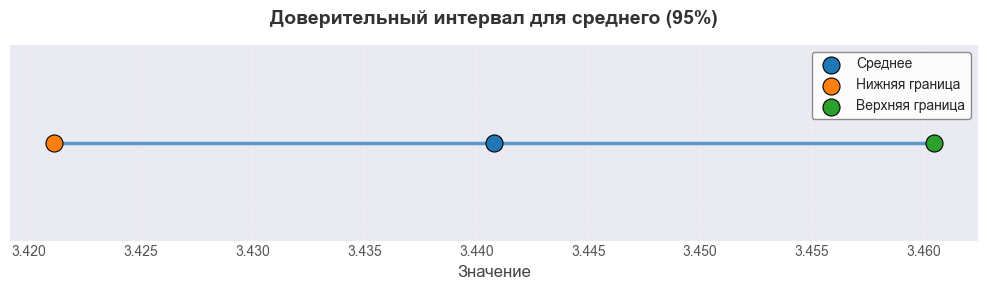

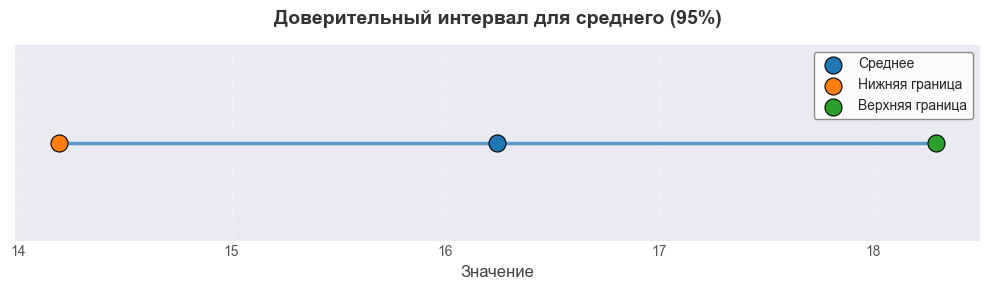

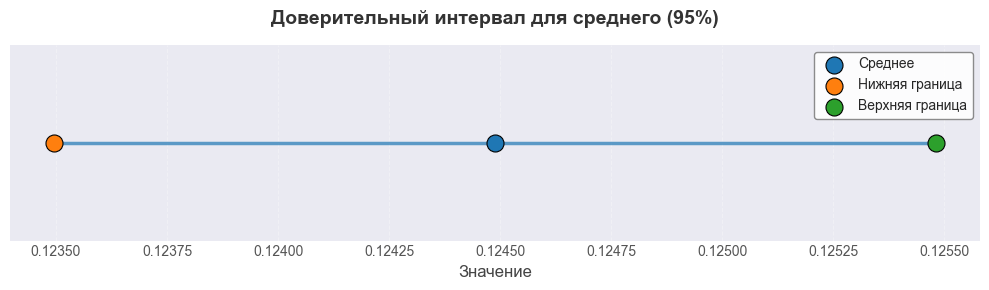

In [10]:
for i, dataset in enumerate(datasets, start=1):
    try:
        plot_confidence_intervals(dataset, confidence_level)
        print()
    except ValueError as e:
        print(f"Ошибка при построении для набора данных {i}: {e}")

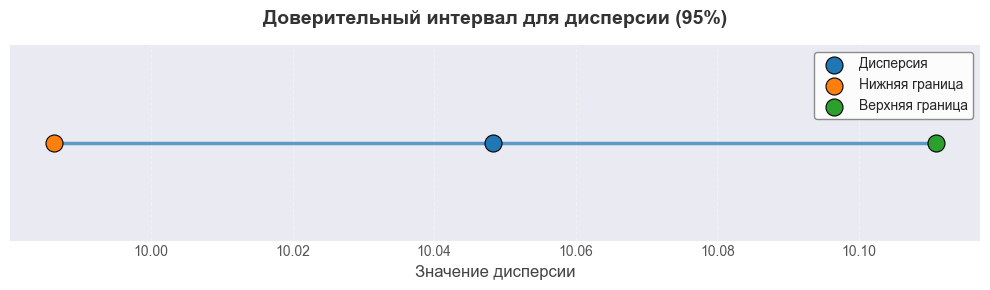

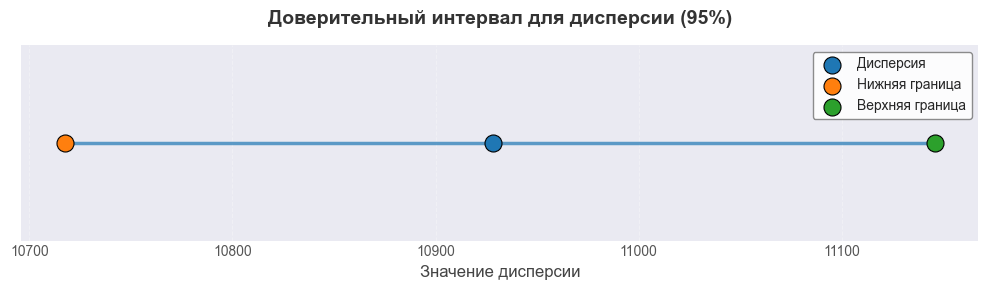

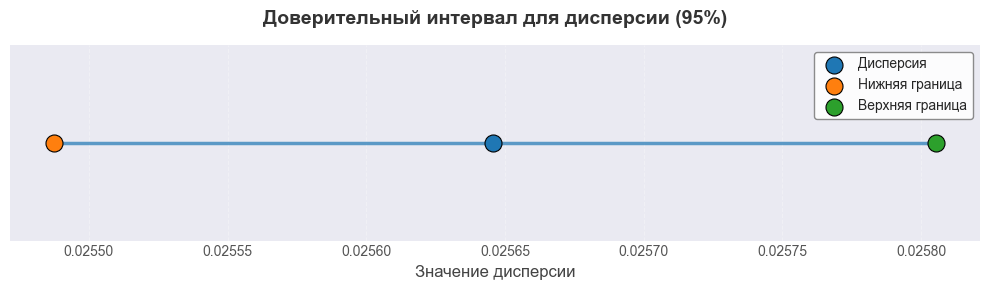

In [11]:
for i, dataset in enumerate(datasets, start=1):
    try:
        plot_confidence_intervals_variance(dataset, confidence_level)
        print()
    except ValueError as e:
        print(f"Ошибка при построении для набора данных {i}: {e}")

### 4. Генерация теоретических распределений

###  Геометрическое распределение
#### - распределение дискретной случайной величины X, принимающей целые неотрицательные значения. 
#### Пусть происходит серия независимых испытаний, в каждом из которых событие может появится с одной и той же вероятностью p. Тогда случайная величина X - количество испытаний до первого появления события, имеет геометрическое распределение вероятностей.
$$ M[x] = \frac{1}{p}, D[X] = \frac{q}{p^2} $$

#### Геометрическое распределение строится по формуле:

$$ p_k = P \{X = k\} = q^k \cdot p $$

### Биномиальное распределение.
#### Распределение количества «успехов» в последовательности из n независимых случайных экспериментов, таких, что вероятность «успеха» в каждом из них постоянна и равна p

$$ M[x] = n\cdot p, D[x] = n\cdot p \cdot q $$

#### Дискретная случайная величина X имеет биноминальное распределение, если ее закон распределения описывается формулой Бернулли:
$$ P\{X = k\} = P(n,k) = C_n^k \cdot p^k \cdot q^{n-k} $$

### Распределение Пуассона.

#### Если количество испытаний n достаточно велико, а вероятность p появления события A в отдельно взятом испытании весьма мала (0,05-0,1 и меньше), то вероятность того, что в данной серии испытаний событие A появится ровно k раз, можно приближенно вычислить по формуле Пуассона:
$$ P\{X = k\} = C_n^k \cdot p^k \cdot q^{n-k} = \frac{α^k}{k!}\cdot e^{-α} $$

$$ M[X] = α, D[X] = α $$

### Равномерное распределение.
#### Есть некоторый конечный промежуток - [a, b]. Если случайная величина X обладает постоянной плотностью распределения вероятностей на данном отрезке и нулевой плотностью вне него, то говорят, что она распределена равномерно.

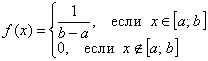

$$ M[X] = \frac{a + b}{2} $$ 
$$ D[X] = \frac{(b - a)^2}{12} $$  

### Нормальное распределение.

#### Нормальное распределение, также называемое распределением Гаусса или Гаусса — Лапласа — распределение вероятностей, которое в одномерном случае задаётся функцией плотности вероятности, совпадающей с функцией Гаусса: 
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left( \frac{x - \mu}{\sigma} \right)^2}
$$

### Экспоненциальное распределение.

#### Экспоненциальное распределение моделирует время между двумя последовательными свершениями события, а параметр λ описывает среднее число наступлений события в единицу времени.

$$ M[X] = \frac{1}{\lambda} $$  

$$ D[X] = \frac{1}{\lambda^2} $$  

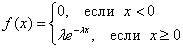

#### Функции генерации данных для стандартных распределений (геометрическое, биномиальное, Пуассона, равномерное, нормальное, экспоненциальное)

In [12]:
def generate_geometric(mean, size=1000):
    """
    Генерирует выборку из геометрического распределения с параметром p.
    P(X=k) = (1-p)^(k-1) * p,  k = 1, 2, ...
    """
    p = 1 / mean
    return np.random.geometric(p, size=size)


def generate_binomial(n, p, size=1000):
    """
    Генерирует выборку из биномиального распределения.
    """
    return np.random.binomial(n, p, size=size)


def generate_poisson(lam, size=1000):
    """
    Генерирует выборку из распределения Пуассона.
    """
    return np.random.poisson(lam, size=size)


def generate_uniform(a, b, size=1000):
    """
    Генерирует выборку из равномерного распределения U(a, b).
    """
    return np.random.uniform(a, b, size=size)


def generate_normal(mean, sigma, size=1000):
    """
    Генерирует выборку из нормального распределения.
    """
    return np.random.normal(mean, sigma, size=size)


def generate_exponential(mean, size=1000):
    """
    Генерирует выборку из экспоненциального распределения.
    """
    lam =1/mean
    return np.random.exponential(1.0 / lam, size=size)


#### Правило Стерджеса для определения оптимального количества интервалов, на которые разбивается диапазон изменения случайной величины

#### Количество интервалов n определяется как:
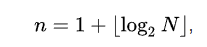
#### Часто встречается записанным через десятичный логарифм

#### Где N - общее число наблюдений величины.

In [13]:
def calculate_sturges(data: np.ndarray) -> int:
    n = len(data)
    if n == 0:
        return 1
    
    num_int = 1 + math.floor(np.log2(n))
    return num_int

#### Функция построения гистограмм

In [14]:
def plot_two_histograms(data1, data2, title, label1='Data 1', label2='Data 2', 
                        color1='#1f77b4', color2='#ff7f0e'):
    """
    Строит две наложенные гистограммы для двух наборов данных.
    
    Parameters:
    - data1, data2: два набора данных для отображения.
    - title: Заголовок графика.
    - label1, label2: метки для каждого набора данных (по умолчанию "Data 1" и "Data 2").
    - color1, color2: цвета для каждого набора данных (по умолчанию синий и оранжевый).
    """
    
    # Установка стиля Seaborn для современного вида
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Объединяем данные для расчёта общих бинов
    all_data = np.concatenate([data1, data2])
    bins_count = calculate_sturges(all_data)
    bins_min, bins_max = all_data.min(), all_data.max()
    bins = np.linspace(bins_min, bins_max, bins_count + 1)
    
    # Создание фигуры
    plt.figure(figsize=(10, 6))
    
    # Гистограмма для первого набора данных
    plt.hist(
        data1,
        bins=bins,
        density=True,
        alpha=0.6,  
        color=color1, 
        edgecolor='black',
        linewidth=0.8,
        label=label1,
        histtype="stepfilled"
    )
    
    # Гистограмма для второго набора данных
    plt.hist(
        data2,
        bins=bins,
        density=True,
        alpha=0.6, 
        color=color2,  
        edgecolor='black',
        linewidth=0.8,
        label=label2,
        histtype="stepfilled"
    )
    
    # Настройка заголовка и подписей
    plt.title(title, fontsize=16, fontweight='bold', color='#333333', pad=15)
    plt.xlabel("Значение", fontsize=12, color='#444444')
    plt.ylabel("Плотность", fontsize=12, color='#444444')
    
    # Легенда
    plt.legend(loc='upper right', fontsize=10, frameon=True, edgecolor='gray', facecolor='white', framealpha=0.9)
    
    # Настройка осей
    plt.tick_params(axis='both', labelsize=10, colors='#555555')
    
    # Сетка
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    
    # Улучшение компоновки
    plt.tight_layout()
    
    plt.show()

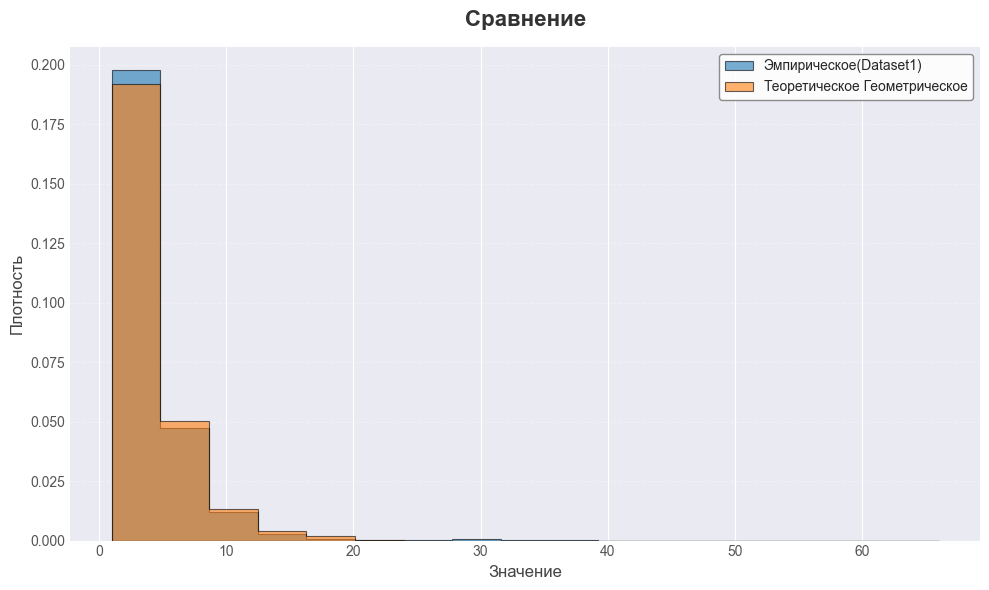

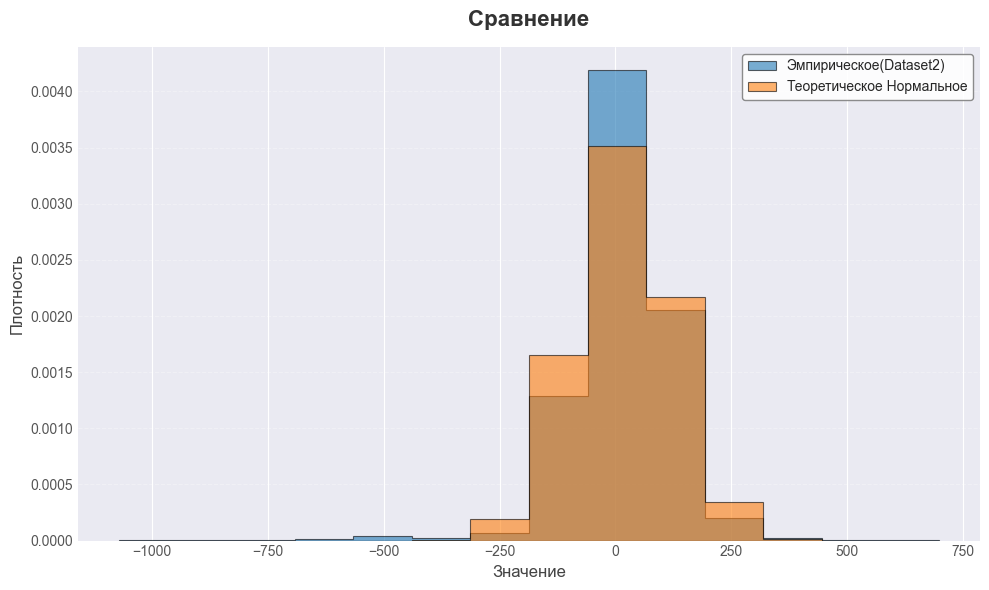

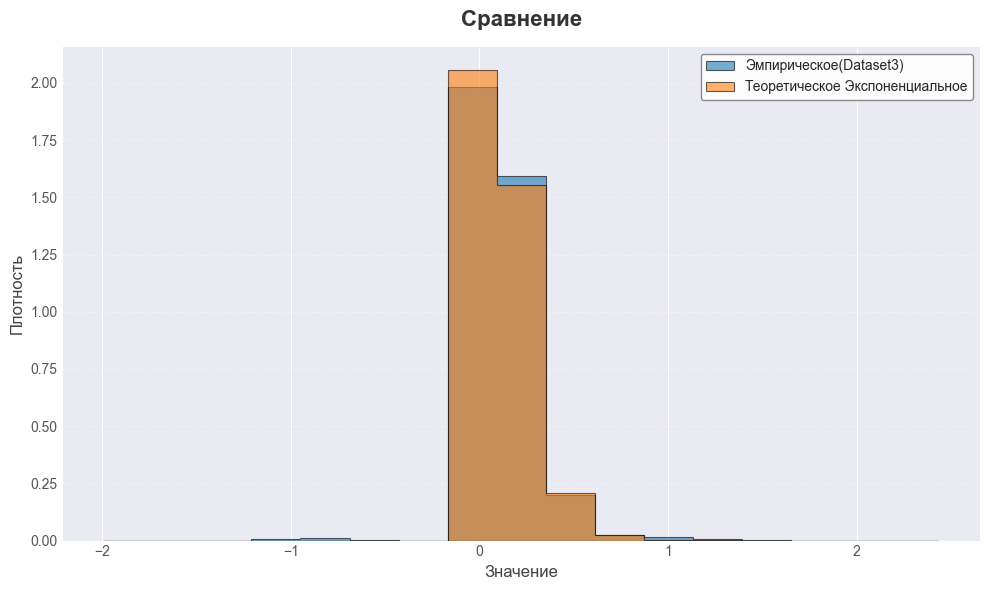

In [15]:
for i, dataset in enumerate(datasets, start=1):
    try:
        mean_emp = calculate_mean(dataset)
        var_emp = calculate_unbiased_variance(dataset)

        if i == 1:
            mean_emp = calculate_mean(dataset)
            theo_sample = generate_geometric(mean_emp, size=2000)
            plot_two_histograms(dataset, theo_sample, title="Сравнение", label1="Эмпирическое(Dataset1)", label2="Теоретическое Геометрическое")
        
        elif i == 2:
            mean_emp = calculate_mean(dataset)
            var_emp = calculate_unbiased_variance(dataset)
            theo_sample = generate_normal(mean_emp, np.sqrt(var_emp), size=5000)
            plot_two_histograms(dataset, theo_sample, title="Сравнение", label1="Эмпирическое(Dataset2)", label2="Теоретическое Нормальное")
        
        elif i == 3:
            mean_emp = calculate_mean(dataset)
            theo_sample = generate_exponential(mean_emp, size=3000)
            plot_two_histograms(dataset, theo_sample, title="Сравнение", label1="Эмпирическое(Dataset3)", label2="Теоретическое Экспоненциальное")

    except ValueError as e:
        print(f"Ошибка при построении для набора данных {i}: {e}")

#### Подходящее теоретическое распределение для каждого набора данных:
#### set_1.csv: геометрическое распределение.
#### set_2.csv: нормальное распределение.
#### set_3.csv: экспоненциальное распределение.

### 5. Проверка гипотез

#### Критерий Колмогорова–Смирнова (K-S)

Критерий Колмогорова (или критерий согласия Колмогорова) используется для проверки гипотезы о том, что выборка данных принадлежит заданному теоретическому распределению. Критерий основан на сравнении эмпирической функции распределения с теоретической функцией распределения.

1. Эмпирическая функция распределения $F_n(x)$ определяется как  
   $$
   F_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbf{I}\{X_i \le x\}.
   $$

2. Статистика критерия:
   $$
   D_n = \sup_{x} \Bigl|F_n(x) - F(x)\Bigr|.
   $$
   Чем больше $D_n$, тем больше расхождение эмпирического распределения с теоретическим $F$.

In [16]:
def generate_geometric(mean, size=1000):
    """
    Генерирует выборку из геометрического распределения с параметром p.
    P(X=k) = (1-p)^(k-1) * p,  k = 1, 2, ...
    """
    p = 1 / mean
    return np.random.geometric(p, size=size)

def generate_normal(mean, sigma, size=1000):
    """
    Генерирует выборку из нормального распределения.
    """
    return np.random.normal(mean, sigma, size=size)


def generate_exponential(mean, size=1000):
    """
    Генерирует выборку из экспоненциального распределения.
    """
    lam = 1/mean
    return np.random.exponential(1.0 / lam, size=size)


def normal_cdf(x, mu=0.0, sigma=1.0):
    """Функция распределения для нормального распределения"""
    try:
        z = (x - mu) / sigma
        return 0.5 * (1 + math.erf(z / math.sqrt(2)))
    except (OverflowError, ValueError):
        if x > mu:
            return 1.0
        else:
            return 0.0


def exponential_cdf(x, lambda_param):
    """Функция распределения для экспоненциального распределения"""
    if x < 0:
        return 0.0
    try:
        return 1 - math.exp(-lambda_param * x)
    except (OverflowError, ValueError):
        # Если экспонента слишком большая, возвращаем 1
        return 1.0


def uniform_cdf(x, a, b):
    """Функция распределения для равномерного распределения"""
    if x < a:
        return 0.0
    elif x > b:
        return 1.0
    else:
        return (x - a) / (b - a)


def poisson_cdf(x, lambda_param):
    """Функция распределения для распределения Пуассона"""
    if x < 0:
        return 0.0
    k = int(x)
    
    if k > 100 or lambda_param > 100:
        mu = lambda_param
        sigma = math.sqrt(lambda_param)
        return normal_cdf(k + 0.5, mu, sigma)
    
    result = 0.0
    try:
        for i in range(k + 1):
            term = (lambda_param ** i) * math.exp(-lambda_param) / math.factorial(i)
            result += term
    except (OverflowError, ValueError):
        mu = lambda_param
        sigma = math.sqrt(lambda_param)
        return normal_cdf(k + 0.5, mu, sigma)
    
    return result


def binomial_cdf(x, n, p):
    """Функция распределения для биномиального распределения"""
    if x < 0:
        return 0.0
    k = min(int(x), n)
    
    if n > 50:
        mu = n * p
        sigma = math.sqrt(n * p * (1 - p))
        return normal_cdf(k + 0.5, mu, sigma)
    
    result = 0.0
    try:
        for i in range(k + 1):
            log_coef = math.log(math.comb(n, i)) if i > 0 else 0
            log_p_term = i * math.log(p) if p > 0 else float('-inf')
            log_q_term = (n - i) * math.log(1 - p) if p < 1 else float('-inf')
            
            term = math.exp(log_coef + log_p_term + log_q_term)
            result += term
    except (OverflowError, ValueError):
        mu = n * p
        sigma = math.sqrt(n * p * (1 - p))
        return normal_cdf(k + 0.5, mu, sigma)
    
    return result


def geometric_cdf(x, p):
    """Функция распределения для геометрического распределения"""
    if x < 1:
        return 0.0
    try:
        return 1 - (1 - p) ** int(x)
    except (OverflowError, ValueError):
        return 1.0



def estimate_normal_params(data):
    """Оценка параметров нормального распределения"""
    mu = np.mean(data)
    sigma = np.std(data, ddof=0)  
    return mu, sigma


def estimate_exponential_param(data):
    """Оценка параметра экспоненциального распределения"""
    return 1.0 / np.mean(data)  


def estimate_uniform_params(data):
    """Оценка параметров равномерного распределения"""
    return np.min(data), np.max(data)


def estimate_poisson_param(data):
    """Оценка параметра распределения Пуассона"""
    return np.mean(data)


def estimate_binomial_params(data):
    """Оценка параметров биномиального распределения"""
    n_est = int(np.max(data))
    p_est = np.mean(data) / n_est if n_est > 0 else 0
    return n_est, p_est


def estimate_geometric_param(data):
    """Оценка параметра геометрического распределения"""
    return 1.0 / np.mean(data)  # p = 1/mean


def ks_test(data, cdf_func):
    """
    Критерий Колмогорова-Смирнова
    
    Args:
        data: Массив данных
        cdf_func: Функция распределения теоретического распределения
        
    Returns:
        D: Статистика Колмогорова-Смирнова
        p_value: p-значение
    """
    n = len(data)
    if n == 0:
        return 0.0, 1.0
    
    data_sorted = np.sort(data)
    
    D = 0.0
    for i, x in enumerate(data_sorted):
        F_emp_after = (i + 1) / n  
        F_emp_before = i / n       
        
        try:
            F_theo = cdf_func(x)
        except (OverflowError, ValueError):
            if x > 0:
                F_theo = 1.0
            else:
                F_theo = 0.0
        
        D = max(D, abs(F_emp_after - F_theo), abs(F_emp_before - F_theo))
    
    try:
        if n > 35:
            p_value = math.exp(-2 * n * D * D)
        else:
            lam = (math.sqrt(n) + 0.12 + 0.11 / math.sqrt(n)) * D
            j = 1
            sum_term = 0
            while True:
                term = (-1)**(j-1) * math.exp(-2 * j**2 * lam**2)
                sum_term += term
                if abs(term) < 1e-10 or j > 100:  
                    break
                j += 1
            p_value = 1 - 2 * sum_term
    except (OverflowError, ValueError):
        p_value = 0.001
    
    p_value = max(0, min(p_value, 1))
    
    return D, p_value



def test_distribution(data, dist_type, significance_level=0.05):
    """
    Проверяет гипотезу о соответствии данных указанному распределению
    
    Args:
        data: Массив данных для проверки
        dist_type: Тип распределения ('normal', 'exponential', 'uniform', 'poisson', 'binomial', 'geometric')
        significance_level: Уровень значимости для проверки гипотезы
        
    Returns:
        accepted: True, если гипотеза не отвергается, False - иначе
        D: Значение статистики Колмогорова-Смирнова
        p_value: p-значение теста
    """
    try:
        # Определение функции распределения в зависимости от типа
        if dist_type == 'normal':
            mu, sigma = estimate_normal_params(data)
            cdf = lambda x: normal_cdf(x, mu, sigma)
            dist_name = f"нормальное распределение (μ={mu:.4f}, σ={sigma:.4f})"
        elif dist_type == 'exponential':
            lambda_param = estimate_exponential_param(data)
            cdf = lambda x: exponential_cdf(x, lambda_param)
            dist_name = f"экспоненциальное распределение (λ={lambda_param:.4f})"
        elif dist_type == 'uniform':
            a, b = estimate_uniform_params(data)
            cdf = lambda x: uniform_cdf(x, a, b)
            dist_name = f"равномерное распределение (a={a:.4f}, b={b:.4f})"
        elif dist_type == 'poisson':
            lambda_param = estimate_poisson_param(data)
            cdf = lambda x: poisson_cdf(x, lambda_param)
            dist_name = f"распределение Пуассона (λ={lambda_param:.4f})"
        elif dist_type == 'binomial':
            n, p = estimate_binomial_params(data)
            cdf = lambda x: binomial_cdf(x, n, p)
            dist_name = f"биномиальное распределение (n={n}, p={p:.4f})"
        elif dist_type == 'geometric':
            p = estimate_geometric_param(data)
            cdf = lambda x: geometric_cdf(x, p)
            dist_name = f"геометрическое распределение (p={p:.4f})"
        else:
            raise ValueError(f"Неизвестный тип распределения: {dist_type}")
        
        D, p_value = ks_test(data, cdf)
        
        print(f"Проверка соответствия: {dist_name}")
        print(f"Статистика D = {D:.4f}")
        print(f"p-значение = {p_value:.4f}")
        print(f"Уровень значимости = {significance_level:.4f}")
        
        accepted = p_value > significance_level
        if accepted:
            print(f"ВЫВОД: Гипотеза НЕ ОТВЕРГАЕТСЯ (p > {significance_level})")
            print(f"Данные соответствуют распределению: {dist_name}")
        else:
            print(f"ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ {significance_level})")
            print(f"Данные НЕ соответствуют распределению: {dist_name}")
        
        print("-" * 80)
        return accepted, D, p_value
    
    except Exception as e:
        print(f"Ошибка при проверке на {dist_type}: {str(e)}")
        print("-" * 80)
        return False, 0, 0

#### Анализ Dataset 1

In [17]:

data_set1 = np.genfromtxt('set_1.csv', delimiter=',')

print("\n" + "=" * 80)
print("DATASET 1")
print("=" * 80)
    
print(f"Размер выборки: {len(data_set1)}")
print(f"Минимум: {np.min(data_set1):.4f}")
print(f"Максимум: {np.max(data_set1):.4f}")
print(f"Среднее: {np.mean(data_set1):.4f}")
print(f"Медиана: {np.median(data_set1):.4f}")
print(f"Стандартное отклонение: {np.std(data_set1):.4f}")
   
print("\nПроверка гипотез методом Колмогорова-Смирнова для dataset 1:")
test_distribution(data_set1, 'normal')
test_distribution(data_set1, 'exponential')
test_distribution(data_set1, 'uniform')
test_distribution(data_set1, 'geometric')
    


DATASET 1
Размер выборки: 100000
Минимум: 1.0000
Максимум: 66.0000
Среднее: 3.4408
Медиана: 2.0000
Стандартное отклонение: 3.1699

Проверка гипотез методом Колмогорова-Смирнова для dataset 1:
Проверка соответствия: нормальное распределение (μ=3.4408, σ=3.1699)
Статистика D = 0.2207
p-значение = 0.0000
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: нормальное распределение (μ=3.4408, σ=3.1699)
--------------------------------------------------------------------------------
Проверка соответствия: экспоненциальное распределение (λ=0.2906)
Статистика D = 0.2522
p-значение = 0.0000
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: экспоненциальное распределение (λ=0.2906)
--------------------------------------------------------------------------------
Проверка соответствия: равномерное распределение (a=1.0000, b=66.0000)
Статистика D = 0.8310
p-значение = 0.0000
Уровень значим

(False, np.float64(0.2906317753532629), 0)

#### Анализ Dataset 2

In [18]:
data_set2 = np.genfromtxt('set_2.csv', delimiter=',')

print("\n" + "=" * 80)
print("DATASET 2")
print("=" * 80)
    
print(f"Размер выборки: {len(data_set2)}")
print(f"Минимум: {np.min(data_set2):.4f}")
print(f"Максимум: {np.max(data_set2):.4f}")
print(f"Среднее: {np.mean(data_set2):.4f}")
print(f"Медиана: {np.median(data_set2):.4f}")
print(f"Стандартное отклонение: {np.std(data_set2):.4f}")
   
print("\nПроверка гипотез методом Колмогорова-Смирнова для dataset 2:")
test_distribution(data_set2, 'normal')
test_distribution(data_set2, 'exponential')
test_distribution(data_set2, 'uniform')
test_distribution(data_set2, 'poisson')


DATASET 2
Размер выборки: 10000
Минимум: -1071.7867
Максимум: 698.7780
Среднее: 16.2433
Медиана: 18.8706
Стандартное отклонение: 104.5342

Проверка гипотез методом Колмогорова-Смирнова для dataset 2:
Проверка соответствия: нормальное распределение (μ=16.2433, σ=104.5342)
Статистика D = 0.0529
p-значение = 0.0000
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: нормальное распределение (μ=16.2433, σ=104.5342)
--------------------------------------------------------------------------------
Проверка соответствия: экспоненциальное распределение (λ=0.0616)
Статистика D = 0.4117
p-значение = 0.0000
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: экспоненциальное распределение (λ=0.0616)
--------------------------------------------------------------------------------
Проверка соответствия: равномерное распределение (a=-1071.7867, b=698.7780)
Статистика D = 0.4886
p-значение = 0.

(False, np.float64(0.4577555219469993), 0)

#### Анализ Dataset 3

In [19]:
data_set3 = np.genfromtxt('set_3.csv', delimiter=',')

print("\n" + "=" * 80)
print("DATASET 3")
print("=" * 80)
    
print(f"Размер выборки: {len(data_set3)}")
print(f"Минимум: {np.min(data_set3):.4f}")
print(f"Максимум: {np.max(data_set3):.4f}")
print(f"Среднее: {np.mean(data_set3):.4f}")
print(f"Медиана: {np.median(data_set3):.4f}")
print(f"Стандартное отклонение: {np.std(data_set3):.4f}")
    
print("\nПроверка гипотез методом Колмогорова-Смирнова для dataset 3:")
test_distribution(data_set3, 'normal')
test_distribution(data_set3, 'exponential')
test_distribution(data_set3, 'uniform')
test_distribution(data_set3, 'binomial')


DATASET 3
Размер выборки: 100000
Минимум: -1.9898
Максимум: 2.4331
Среднее: 0.1245
Медиана: 0.0863
Стандартное отклонение: 0.1601

Проверка гипотез методом Колмогорова-Смирнова для dataset 3:
Проверка соответствия: нормальное распределение (μ=0.1245, σ=0.1601)
Статистика D = 0.2136
p-значение = 0.0000
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: нормальное распределение (μ=0.1245, σ=0.1601)
--------------------------------------------------------------------------------
Проверка соответствия: экспоненциальное распределение (λ=8.0329)
Статистика D = 0.0052
p-значение = 0.0048
Уровень значимости = 0.0500
ВЫВОД: Гипотеза ОТВЕРГАЕТСЯ (p ≤ 0.05)
Данные НЕ соответствуют распределению: экспоненциальное распределение (λ=8.0329)
--------------------------------------------------------------------------------
Проверка соответствия: равномерное распределение (a=-1.9898, b=2.4331)
Статистика D = 0.4450
p-значение = 0.0000
Уровень значим

(False, 0.8744858928425339, 0)

### 6. Сопоставление и анализ

#### Графическое сопоставление эмпирическиех данных с теоретическими распределениями

In [20]:
def normal_pdf(x, mu=0.0, sigma=1.0):
    try:
        return (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    except (OverflowError, ValueError):
        return 0.0


def exponential_pdf(x, lambda_param):
    if x < 0:
        return 0.0
    try:
        return lambda_param * math.exp(-lambda_param * x)
    except (OverflowError, ValueError):
        return 0.0

def geometric_pmf(k, p):
    if k < 1:
        return 0.0
    try:
        k = int(k)
        return (1 - p) ** (k - 1) * p
    except (OverflowError, ValueError):
        return 0.0


def plot_distribution_comparison(data, dist_type, title="Сопоставление эмпирических данных с теоретическим распределением"):
    """
    Создает графики для сравнения эмпирического распределения с теоретическим.
    Включает:
    1. Гистограмму с наложенной теоретической плотностью
    2. Сравнение эмпирической и теоретической функций распределения
    """
    if dist_type == 'normal':
        mu, sigma = estimate_normal_params(data)
        pdf = lambda x: normal_pdf(x, mu, sigma)
        cdf = lambda x: normal_cdf(x, mu, sigma)
        dist_name = f"нормальное распределение (μ={mu:.4f}, σ={sigma:.4f})"
        is_discrete = False
    elif dist_type == 'exponential':
        lambda_param = estimate_exponential_param(data)
        pdf = lambda x: exponential_pdf(x, lambda_param)
        cdf = lambda x: exponential_cdf(x, lambda_param)
        dist_name = f"экспоненциальное распределение (λ={lambda_param:.4f})"
        is_discrete = False
    elif dist_type == 'geometric':
        p = estimate_geometric_param(data)
        pmf = lambda k: geometric_pmf(k, p)
        cdf = lambda x: geometric_cdf(x, p)
        dist_name = f"геометрическое распределение (p={p:.4f})"
        is_discrete = True
    else:
        raise ValueError(f"Неизвестный тип распределения: {dist_type}")
    
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f"{title}: {dist_name}", fontsize=16, fontweight='bold', color='#333333')
    
    # График плотности/вероятности
    ax1.set_title("Функция плотности/вероятности", fontsize=14, color='#444444')
    
    if is_discrete:
        unique_values = sorted(list(set([int(x) for x in data])))
        counts = {}
        for value in data:
            value = int(value)
            counts[value] = counts.get(value, 0) + 1
        
        total = len(data)
        for value in counts:
            counts[value] /= total
        
        x_values = list(range(min(unique_values), min(max(unique_values) + 1, 100)))
        y_freq = [counts.get(x, 0) for x in x_values]
        
        # Стиль для дискретного распределения
        ax1.bar(x_values, y_freq, alpha=0.6, color='#1f77b4', label='Эмпирические частоты', edgecolor='black', linewidth=0.5)
        y_theoretical = [pmf(x) for x in x_values]
        ax1.plot(x_values, y_theoretical, 'o-', color='#ff7f0e', linewidth=2, markersize=6, label='Теоретические вероятности')
        ax1.set_xlim(0, min(50, max(unique_values)))
    else:
        bins = calculate_sturges(data)
        # Стиль для непрерывного распределения
        ax1.hist(data, bins=bins, density=True, alpha=0.6, color='#2ca02c', label='Эмпирическая плотность', edgecolor='black', linewidth=0.5)
        x_range = np.linspace(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)), 1000)
        y_theoretical = [pdf(x) for x in x_range]
        ax1.plot(x_range, y_theoretical, '-', color='#d62728', linewidth=2.5, label='Теоретическая плотность')
    
    ax1.set_xlabel('Значение', fontsize=12, color='#444444')
    ax1.set_ylabel('Плотность/Вероятность', fontsize=12, color='#444444')
    ax1.legend(fontsize=10, frameon=True, edgecolor='gray')
    ax1.tick_params(axis='both', labelsize=10, colors='#555555')
    
    # График функции распределения (CDF)
    ax2.set_title("Функция распределения (CDF)", fontsize=14, color='#444444')
    
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax2.step(sorted_data, ecdf, where='post', label='Эмпирическая CDF', color='#1f77b4', linewidth=2.5, linestyle='--')
    
    if is_discrete:
        x_max = min(int(max(data)) + 1, 100)
        x_values = list(range(0, x_max))
        y_cdf = [cdf(x) for x in x_values]
        ax2.step(x_values, y_cdf, where='post', color='#ff7f0e', linewidth=2.5, label='Теоретическая CDF')
        ax2.set_xlim(0, min(50, x_max))
    else:
        x_range = np.linspace(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)), 1000)
        y_cdf = [cdf(x) for x in x_range]
        ax2.plot(x_range, y_cdf, '-', color='#d62728', linewidth=2.5, label='Теоретическая CDF')
    
    # Рассчитываем D-статистику
    D = 0.0
    for i, x in enumerate(sorted_data):
        F_emp_after = (i + 1) / len(data)
        F_emp_before = i / len(data)
        try:
            F_theo = cdf(x)
        except:
            F_theo = 1.0 if x > 0 else 0.0
        D = max(D, abs(F_emp_after - F_theo), abs(F_emp_before - F_theo))
    
    # Добавляем D-статистику с улучшенным стилем
    ax2.text(0.05, 0.95, f"Статистика D = {D:.4f}", 
             transform=ax2.transAxes, fontsize=12, color='#333333',
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax2.set_xlabel('Значение', fontsize=12, color='#444444')
    ax2.set_ylabel('Вероятность P(X ≤ x)', fontsize=12, color='#444444')
    ax2.legend(fontsize=10, frameon=True, edgecolor='gray')
    ax2.tick_params(axis='both', labelsize=10, colors='#555555')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return D


Размер выборки: 100000
Среднее значение: 3.4408
Оценка параметра p: 0.2906


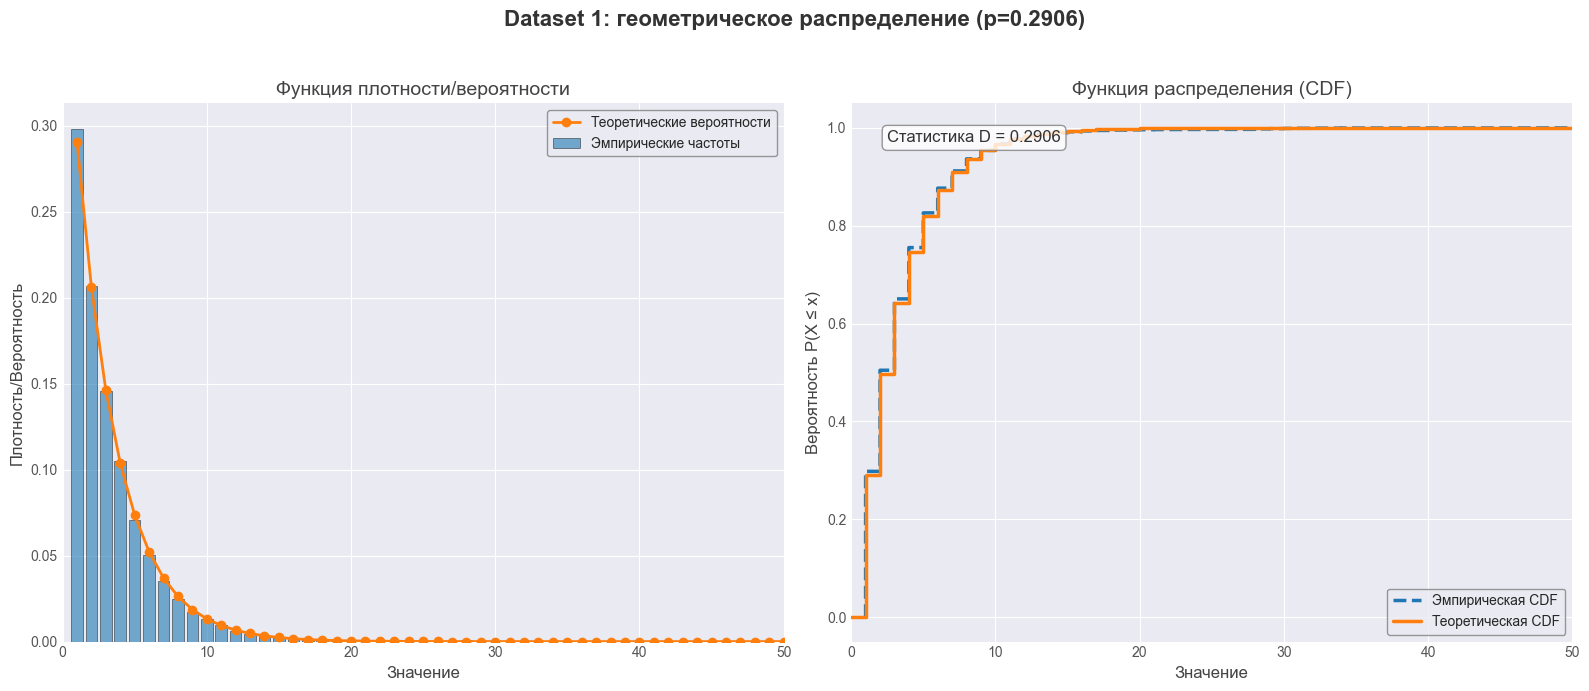

Размер выборки: 10000
Оценка параметров: μ = 16.2433, σ = 104.5342


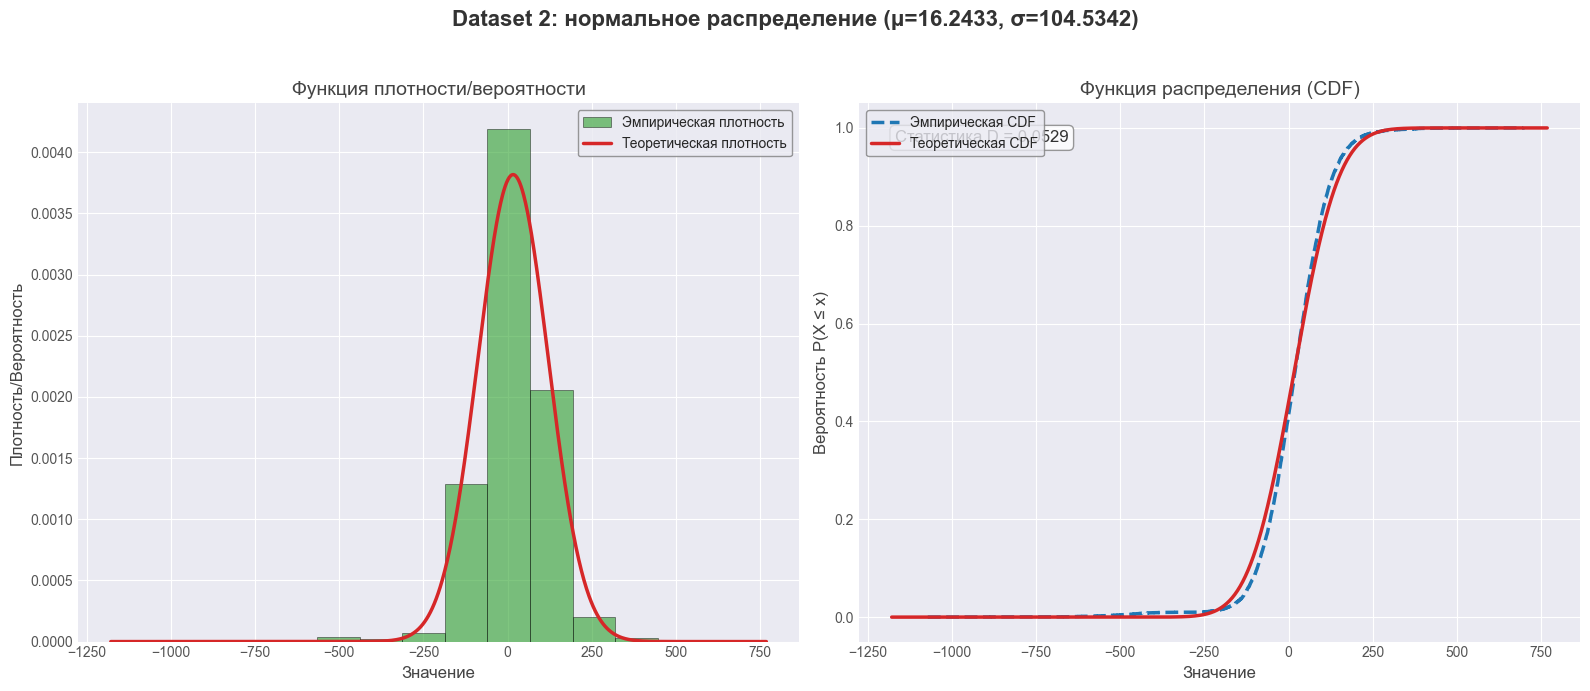

Размер выборки: 100000
Оценка параметра λ: 8.0329


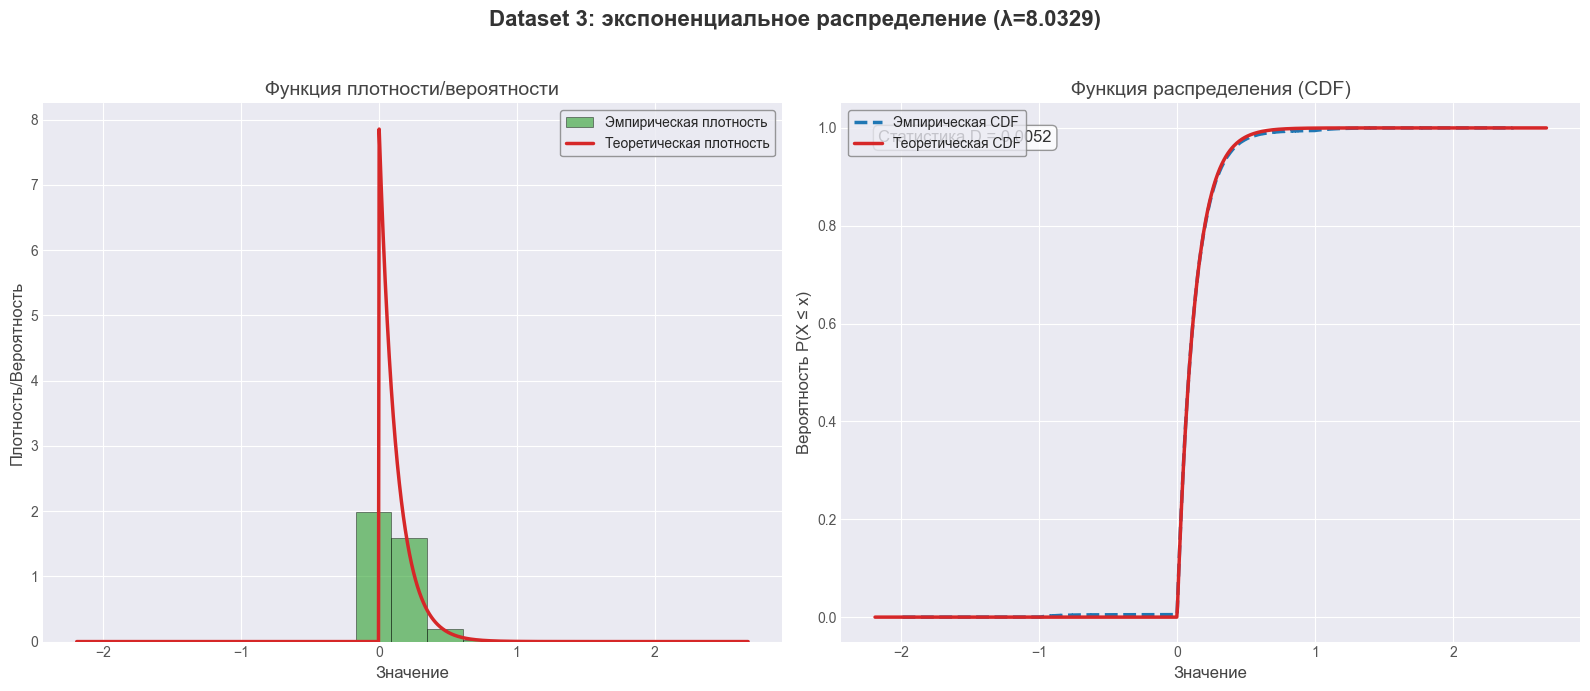

In [21]:
for i, dataset in enumerate(datasets, start=1):
    try:
        mean_emp = calculate_mean(dataset)
        var_emp = calculate_unbiased_variance(dataset)

        if i == 1:
            print(f"Размер выборки: {len(dataset)}")
            print(f"Среднее значение: {np.mean(dataset):.4f}")
            p_est = estimate_geometric_param(dataset)
            print(f"Оценка параметра p: {p_est:.4f}")
            D1 = plot_distribution_comparison(dataset, 'geometric', "Dataset 1")
        
        elif i == 2:
            print(f"Размер выборки: {len(dataset)}")
            mu, sigma = estimate_normal_params(dataset)
            print(f"Оценка параметров: μ = {mu:.4f}, σ = {sigma:.4f}")
            D2 = plot_distribution_comparison(dataset, 'normal', "Dataset 2")
        
        elif i == 3:
            print(f"Размер выборки: {len(dataset)}")
            lambda_est = estimate_exponential_param(dataset)
            print(f"Оценка параметра λ: {lambda_est:.4f}")
            D3 = plot_distribution_comparison(dataset, 'exponential', "Dataset 3")

    except ValueError as e:
        print(f"Ошибка при построении для набора данных {i}: {e}")

#### Результаты

In [22]:
print(f"Датасет 1 - Геометрическое распределение: D = {D1:.4f}")
print(f"Датасет 2 - Нормальное распределение: D = {D2:.4f}")
print(f"Датасет 3 - Экспоненциальное распределение: D = {D3:.4f}")

Датасет 1 - Геометрическое распределение: D = 0.2906
Датасет 2 - Нормальное распределение: D = 0.0529
Датасет 3 - Экспоненциальное распределение: D = 0.0052
